In [224]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

### file hierarchy and database connection vars

In [ ]:
# directory & file hierarchy
iterationName = 'e1'
exp_path = 'museumdraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    


In [ ]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['E1c']
coll2 = db['E1d']

### render out all pngs you can find!

In [ ]:
really_run = 1
if really_run:
    
    ## render out first batch: E1c
    final_images = coll.find({'dataType':'finalImage'}).sort('time')
    imsize = 224
    for rec in final_images:
        imgData = rec['imgData'];
        filestr = base64.b64decode(imgData)
        if rec['time']> 1510252452134: ## this is the timepoint after which real data started getting collected
            if 'age' in rec.keys():
                category_dir = os.path.join(sketch_dir,rec['category'])
                if not os.path.exists(category_dir):
                    os.makedirs(category_dir)
                fname = os.path.join(category_dir,'{}_sketch_{}_{}.png'.format(rec['category'], rec['age'],rec['sessionId']))
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                
    ## render out second batch: E1d
    final_images = coll2.find({'dataType':'finalImage'}).sort('time')
    imsize = 224
    for rec in final_images:
        imgData = rec['imgData'];
        filestr = base64.b64decode(imgData)
        if rec['time']> 1510252452134: ## this is the timepoint after which real data started getting collected
            if 'age' in rec.keys():
                category_dir = os.path.join(sketch_dir,rec['category'])
                if not os.path.exists(category_dir):
                    os.makedirs(category_dir)
                fname = os.path.join(category_dir,'{}_sketch_{}_{}.png'.format(rec['category'], rec['age'],rec['sessionId']))
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))                    


### Preprocessing data

Notes:

The collection that contains the data we will analyze for VSS is called 'E1c'. There were 16 categories in this set. 

12/19/17: We expanded the set of classes from 16 classes to 22 classes. These are saved under the experiment name 'E1d.'

There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".




In [ ]:
# wave 1 of data collection (16 classes)
experiment_name = 'E1c'
time_threshold = 1510252452134 ## this is the timepoint after which real data started getting collected
all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
valid_sessions = coll.find({'time':{'$gt': time_threshold}}).distinct('sessionId')
practice_categories = ['circle','triangle']
print 'We currently have {} valid sessions from {}.'.format(len(valid_sessions), experiment_name)

# wave 2 of data collection (22 classes) 
experiment_name = 'E1d'
valid_sessions += coll2.find({'time':{'$gt': time_threshold}}).distinct('sessionId')
print 'We currently have {} valid sessions, including {}.'.format(len(valid_sessions), experiment_name)

In [ ]:
really_run_this = 1
if really_run_this:
    ## desired output: a dataframe that has trials on the rows, and the following columns:
    ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
    ## PNG string, submission_time, submission_date
    ## to be saved out as a nice tidy CSV
    session_id = []
    trial_num = []
    category = []
    age = []
    num_strokes = []
    mean_pixel_intensity = []
    bounding_box_coords = []
    svg = []
    svg_times = []
    png = []
    submit_time = []
    submit_date = []
    draw_duration = []
    filename = []
    for s in valid_sessions:
        if s.split('_')[0]!='stationPilot0': ## ignore if data comes from station pilot
            print 'Analyzing {}'.format(s)
            if s.split('_')[0]=='E1c':
                this_collection = coll
            elif s.split('_')[0]=='E1d':
                this_collection = coll2
            image_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
            for imrec in image_recs:
                if imrec['category'] not in practice_categories: ## don't save practice category trials
                    stroke_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, 
                                                      {'sessionId':s}, 
                                                      {'dataType':'stroke'},
                                                      {'trialNum': imrec['trialNum']}]}).sort('time')   
                    if stroke_recs.count() > 0: ## only include trials if the drawings are not blank            
                        session_id.append(imrec['sessionId'])        
                        trial_num.append(imrec['trialNum']) 
                        category.append(imrec['category'])
                        age.append(imrec['age'])
                        png.append(imrec['imgData'])
                        submit_time.append(imrec['time'])
                        submit_date.append(imrec['date'])
                        filename.append(os.path.join(sketch_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId'])))
                        num_strokes.append(stroke_recs.count())
                        _svg = [] # this keeps track of the strokes from THIS final image
                        _svg_times = []
                        for strec in stroke_recs:
                            _svg.append(strec['svg'])
                            _svg_times.append(strec['time'])
                        draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
                        svg.append(_svg)
                        svg_times.append(_svg_times)

In [ ]:
if really_run_this:
    X = pd.DataFrame([session_id,trial_num,category,age,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,filename])
    X = X.transpose()
    X.columns = ['session_id','trial_num','category','age','submit_time','submit_date','num_strokes','svg','svg_times','png','draw_duration', 'filename']

In [ ]:
def get_bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

merged_experiment_name = 'E1cd'

if really_run_this:

    ## add mean pixel intensity (amount of ink spilled) & bounding box coords 
    mean_intensity = []
    bounding_box = []
    imsize = 100
    numpix = imsize**2
    thresh = 250
    for i,_d in X.iterrows():
        imgData = _d['png']
        filestr = base64.b64decode(imgData)
        fname = os.path.join('sketch.png')
        with open(fname, "wb") as fh:
            fh.write(imgData.decode('base64'))
        im = Image.open(fname).resize((imsize,imsize))
        _im = np.array(im)
        mean_intensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)
        # bounding box part
        rmin, rmax, cmin, cmax = get_bounding_box(np.array(Image.open(fname)))
        bounding_box.append(tuple((rmin, rmax, cmin, cmax)))

    ## add to dataframe    
    X = X.assign(mean_intensity=pd.Series(mean_intensity).values)
    X = X.assign(bounding_box=pd.Series(bounding_box).values)
    
    # save out csv
    X.to_csv('../preprocessed_data/museumdraw_{}_data.csv'.format(merged_experiment_name))


In [ ]:
X.shape

### load drawing metadata csv back in

In [142]:
data_path = '../preprocessed_data/museumdraw_E1cd_imageData.csv'
X = pd.read_csv(data_path)

### Basic visualizations

In [ ]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.num_strokes.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('number of strokes')

In [ ]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.draw_duration.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('draw duration')

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='num_strokes',order=seq,palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='age',y='draw_duration',order=seq, palette="Greens_d")
plt.ylabel('draw duration (s)')

plt.subplot(1,3,3)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
plt.ylabel('mean pixel intensity')

plt.tight_layout()

### vgg feature analysis 

In [225]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors

from glob import glob
import os

import embedding as emb
reload(emb)
from embedding import *

In [226]:
# retrieve sketch paths
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

def get_label_from_path(path):
    return path.split('.')[-2].split('_')[-1]    

def get_trial_from_path(path):
    return path.split('_')[-2]

def get_subj_from_path(path):
    return path.split('/')[1]

# extract metadata
path_to_sketches = '../sketches'
sketch_paths = sorted(list_files(path_to_sketches))

In [227]:
## number of sketch paths 
print 'Number of sketch paths = {}'.format(len(sketch_paths))

Number of sketch paths = 532


#### extract features

In [196]:
## extract features
layers = ['P1','P2','P3','P4','P5','FC6','FC7']
layer_ind = 6 ### fc6 = 5, fc7 = 6
extractor = FeatureExtractor(sketch_paths,layer=layer_ind)
Features, Labels, Ages, Sessions = extractor.extract_feature_matrix()

Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
stopped!


In [153]:
## handle trials where we didn't have age information
def convert_age(Ages):
    ages = []
    for a in Ages:
        if len(a)>0:
            ages.append(int(a))
        else:
            ages.append(-1)
    return ages
Ages = convert_age(Ages)

In [154]:
# organize metadata into dataframe
Y = pd.DataFrame([Labels,Ages,Sessions])
Y = Y.transpose()
Y.columns = ['label','age','session']
Y.to_csv('METADATA_{}.csv'.format(layers[layer_ind]))

#### preprocessing

In [170]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def preprocess_features(Features, Y):
    # normalize feature vectors & plot full image-level similarity matrix
    _Y = Y.sort_values(['label','age','session'])
    inds = np.array(_Y.index)
    _Features = normalize(Features[inds])
    return _Features, _Y

def save_features(Features, Labels, X, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']
    np.save('FEATURES_{}.npy'.format(layers[layer_num]), Features)
    np.save('LABELS.npy', Labels)
    X.to_csv('METADATA.csv')
    return layers[layer_num]

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))
#     plt.close()        

### preprocess features

In [164]:
## preprocess
_Features, _Y = preprocess_features(Features, Y)

## remove data where you dont have age information
def remove_nans(Features, Y):
    ind = Y.index[(Y['age'] > 0)]
    _Y = Y.loc[ind]
    _Features = Features[ind.tolist()]
    return _Features, _Y

_Features, _Y = remove_nans(_Features, _Y)

# reset pandas dataframe index
_Y = _Y.reset_index()

# save out features & metadata
_Labels = _Y.label.values
layer = save_features(_Features, Labels, _Y, 6)

### quick classification test

In [157]:
#### Quick classification test
FEAT = _Features
LABELS = _Y.label.values
AGES = _Y.age.values

# single train/test split
X_train, X_test, y_train, y_test = train_test_split(
    FEAT, LABELS, test_size=0.25, random_state=0)
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

run_this = 0
if run_this:
    # cross-validated
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, FEAT, LABELS, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.3828125


In [158]:
## see how recognizability changes with age?

scores = []
num_samples = []
age_range = np.arange(4,11)


# width of moving window in # of trials    
window_size = 2
lb = int(min(_Y.age.values))
ub = int(max(_Y.age.values))
num_windows = ub-lb-window_size+2 ##     

for n in np.arange(num_windows):
    start = lb + n
    end = lb + n + window_size
    ind = _Y.index[(_Y['age'] >= start) & (_Y['age'] < end)]
    meta = _Y.loc[ind]
    subFeat = _Features[ind.tolist()]

    FEAT = subFeat
    LABELS = meta.label.values

    # single train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        FEAT, LABELS, test_size=0.4, random_state=0)
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    print '{}-{}y'.format(start, end-1), len(LABELS),clf.score(X_test, y_test)
    num_samples.append(len(LABELS))
    scores.append(clf.score(X_test, y_test))
    

3-4y 75 0.233333333333
4-5y 150 0.25
5-6y 167 0.402985074627
6-7y 160 0.4375
7-8y 188 0.407894736842
8-9y 122 0.408163265306
9-10y 82 0.0909090909091


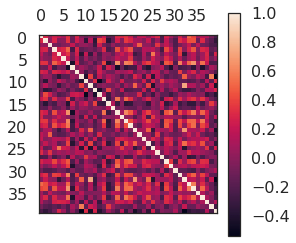

In [159]:
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = _Y.label.values
means = get_class_means(_Features, labels)
CORRMAT = np.corrcoef(means)
plt.matshow(CORRMAT)
plt.colorbar()

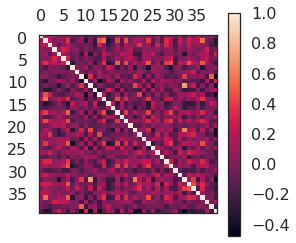

In [160]:
## get RDM for older kids (7,8,9,10)

ind = _Y.index[_Y['age'] > 6]
subY = _Y.loc[ind]
subFeat = _Features[ind.tolist()]

meta = subY
feat = subFeat
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
means = get_class_means(feat, labels)
CORRMAT = np.corrcoef(means)
plt.matshow(CORRMAT)
plt.colorbar()
CORRMAT1 = CORRMAT

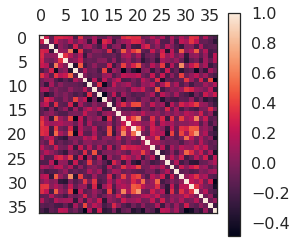

In [161]:
## get RDM for young kids (3,4,5,6)
ind = _Y.index[_Y['age'] <= 6]
subY = _Y.loc[ind]
subFeat = _Features[ind.tolist()]

meta = subY
feat = subFeat
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
means = get_class_means(feat, labels)
CORRMAT = np.corrcoef(means)
plt.matshow(CORRMAT)
plt.colorbar()
CORRMAT2 = CORRMAT

In [184]:
# import scipy.stats as stats
# stats.spearmanr(np.ravel(CORRMAT1),np.ravel(CORRMAT2))

### Extract adult drawing features

In [228]:
import embedding as emb
reload(emb)
from embedding import *

In [233]:
## get list of paths to adult quickdraw drawings
path_png = '/data2/jefan/quickDraw/png'
adult_paths = sorted(list_files(path_png))

In [ ]:
## extract features
layers = ['P1','P2','P3','P4','P5','FC6','FC7']
layer_ind = 6 ### fc6 = 5, fc7 = 6
adult_extractor = FeatureExtractor(adult_paths,layer=layer_ind,cohort='adult')
Features, Labels, Ages, Sessions = adult_extractor.extract_feature_matrix()

Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110
Batch 11